# Local Multi-Variable Moran Statistics

Local Moran statistics are very useful to assess spatial clusters (or outliers) in geographic data. Moran-style statistics are fundamentally based on the *covariance* of an outcome $y_i$ with other observations $y_j$, weighted according to some function that describes how near $i$ is to $j$. Classically, we describe that weight as $w_{ij}$, and collect that into a big matrix, $\mathbf{W}$, that describes the relations between each site and every other site. 

The following discussion is a significantly condensed presentation of that found in [Wolf (2024)](https://doi.org/10.1080/24694452.2024.2326541) pages 1217-1225. 

The classical Moran statistic is stated as the relationship between $y$ and its surroundings. I'm assuming that $y$ is unit standardized, so that it has a mean of zero and a standard deviation of 1. Further, I'm assuming that our weights matrix is row-standardized with a diagonal of zero, meaning that $\sum_j w_{ij} =1$ and $w_{ii}=0$. Further, this means that $\sum_j w_{ij}y_j$ corresponds to the *spatially-weighted average* $y_j$ around $i$. With this understanding, the global $\hat{I}$ estimator is often stated as: 

$$ \hat{I} = \frac{1}{n} \sum_i y_i \sum_j w_{ij}y_j $$

You can understand this also as a kind of least squares estimator, arising from the following regression: 

$$ \mathbf{W}y = Iy + \epsilon \ \ \ \ \ \epsilon \sim \mathcal{N}(0,\sigma^2) $$

In this framing, we can think of the $I$ statistic in vector form as: 

$$ \hat{I} = (y'y)^{-1}y'\mathbf{W}y $$

with the standardization we've used above. The *local* version of this statistic simply "stops" the outer summation over $i$, resulting in $n$ statistics overall:

$$ \hat{I}_i = \frac{1}{n} y_i \sum_j w_{ij} y_j $$

This is equivalent to "stopping" the inner product between $y$ and $\mathbf{W}y$ in the vector form, turning it into an element-wise product (spelled $\circ$ in math below):

$$ \hat{I}_i = (y'y)^{-1}(y \circ \mathbf{W}y)$$

This "incomplete summation" or "inner-to-elementwise trick" is how most of the local statistics are obtained from a global measure of covariance-based association. Any time you take an operation relating all pairs of observations, and sum that (or average that) over all the observations, you can create a "local" measure by just stopping that summation. 

## How do we introduce another variables? 

Often, it's useful to account for the spatial co-variation between two variables. Indeed, a common question is whether the *spatial pattern* of $y$ is similar to that of a second variable, $x$.  Past attempts to link two variables like this include the Wartenberg statistic:

$$ \hat{I}_{xy,i} = x_i \sum_j w_{ij}y_j $$
$$ \hat{\mathbf{I}}_{xy} = x \circ \mathbf{W}y $$

which relates $x_i$ to the local average of $y_j$ nearby. This is useful because it tells you whether a smoothed surface of $y$ looks like the surface of $x$. Perhaps less useful is the Lee (2001) innovation on the statistic, which seeks to compare the two smoothed patterns: 

$$ \hat{L}_i = (\sum_j w_{ij}x_j) * (\sum_j w_{ij}y_j) $$
$$ \hat{\mathbf{L}} = (\mathbf{W}x) \circ (\mathbf{W}y) $$

Both of these statistics are useful in their own ways, but generally are not able to separate out $x$'s influence on $y$ from $y$'s internal patterning over $\mathbf{W}$. Instead, we're stuck making pairwise comparisons across $x$ and $y$ through $\mathbf{W}$. 

## How can we introduce another *exogenous* variable? 

Indeed, it's often the case that $x$ represents some other factor we know is associated with $y$, but which cannot wholly explain $y$. When we just need a global statistic characterizing this relationship, the best solution is to use a spatial model, such as the spatial lag or spatial error models in `spreg`. Creating a local statistic from these models is difficult. Indeed, these models cannot be solved using ordinary least squares, so their non-linear matrix product cannot be "stopped" in the same way as above to create to an element-wise product. While LeSage (2009)'s tools can be used to examine the direct and indirect components of $\beta$, which measure the effect that an intervention on $x$ at a given site at the site of the intervention on average (or, for indirect effects, *surrounding the intervention*), this is not itself a measure of the covariance between $x$ and $y$, nor can it measure the self-similarity of $y$ over $\mathbf{W}$.

Instead, what we often want is to "remove" or "control" for $x$. This "adjusts" $y$ for $x$, and then we can see the spatial pattern in this adjusted $y$. Think, for instance, of spatial clustering in house prices given information on house size. House size is decidedly spatially non-random and also impacts the sale price of a house. While we could develop a price-per-square-foot variable that reflects an adjustment to the house price based on the house size, this cannot scale to multiple factors. 

Another common approach is to to "remove" $x$ from $y$ using a regression. We regress $x$ on $y$ and analyze this model's residuals as if it they were our outcome of interest. That is, we do the first regression: 

$$ y = x\beta + \epsilon $$

using a standard least squares estimator: 

$$ \hat{\beta} = (x'x)^{-1}x'y $$

And use that to build a *residual* $y$, having removed its association with $x$: 

$$ e = y - x (x'x)^{-1} x' y $$

and then use *this* in a Moran-form regression: 

$$ \mathbf{W}e = I_{x\rightarrow y}e + \nu $$

Here, the search for structure in $e$ has already assumed that variation in $y$ is fully "caused by" $x$ *first*. That is, the spatial structure of $y$ that matters is that which is fully independent of $x$'s pattern. This approach is similar to [Restricted Spatial Regression](https://www.tandfonline.com/doi/full/10.1080/01621459.2020.1788949), but proceeds very differently (and thus avoids its counter-intuitive effects). Note that $e = (I-P)y$ in the RSR framing. 

If we estimate this again using the same inner-to-elementwise trick, we can obtain: 

$$ I_{x\rightarrow y} = e \circ \mathbf{W}e (e'e)^{-1}$$

Assuming that there is only one variable $x$, this can be re-stated in terms of $y$ and $x$ with a little algebra: 

$$ I_{x\rightarrow y} = \left[ y\circ \mathbf{W}y - \rho_{xy} x\circ \mathbf{W}y - \rho_{xy} y\circ\mathbf{W}x + \rho^2 x\circ\mathbf{W}x \right] \frac{n-1}{n} \frac{1}{1-\rho_{xy}^2}$$

In this expression, you can see the Moran's $I$ all the way on the left of the bracketed expression, with two Wartenberg $I$s in the middle, and another Moran's $I$ for $x$ on the end. Each term is also scaled by $\rho_{xy}$, depending on the directness of the relationship with $y$. You can think of this as $I$, rescaled by a measure of *indirect covariation* between $y$ and $x$ through $\mathbf{W}$. Graphically, this is represented in the right facet of the following diagram:

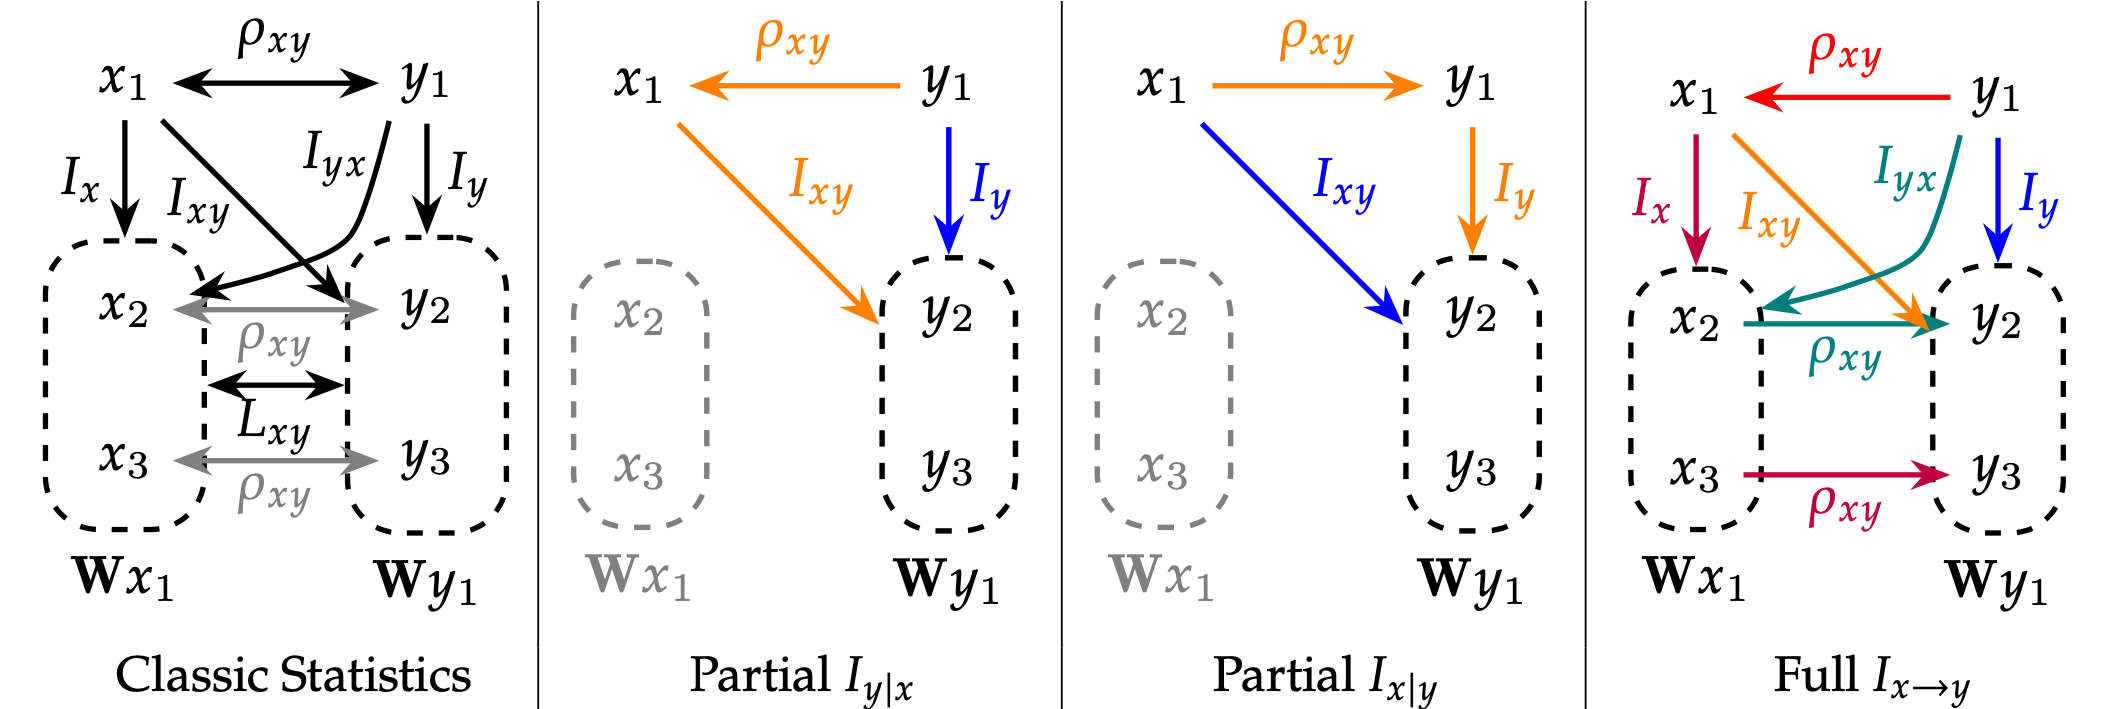

Since we've assumed that all of the variation in $y$ "comes from" $x$ first, we must consider all of the paths through *any* $x$ into $y$. You can see that the correction terms that "flow through" $x$ must be corrected by $\rho_{xy}$ each time. So, for the $I_{x \rightarrow y}$ on the far right of the diagram, we have four possible paths between outcome $y_1$ and nearby avearge outcomes $\mathbf{W}y_1$ at site $1$:

1. The most direct path is from $y_1$ to $\mathbf{W}y_1$, classic $I$
2. Another indirect path goes from $y_1$ through $x_1$, then to $\mathbf{W}y_1$, adjusting the Wartenberg $I$ by $\rho$.
3. A similar indirect path goes from $y_1$ directly to nearby $x_i$, and then to $\mathbf{W}y_1$, resulting in the reversed Wartenberg estimator scaled by $\rho$
4. Another indirect path goes from $y_i$, through $x$, then $\mathbf{W}x_1$, and then to $\mathbf{W}y_1$, involving $\rho$ twice and Moran's $I$ within $x$ alone.

Hence, terms 2 and 3 are represented by the green path and the red+orange path, while term 4 corresponds to the red+maroon path. Terms 2 and 3 are Wartenberg-style bivariate Moran statistics corrected by $\rho_{xy}$, while term 4 is a univariate Moran statistic for $x$, corrected by $\rho_{xy}^2$.

This may look like a bit of an **over-correction**, though! Typically, when we backtrack through a path and correct for the resulting term, we can "delete" those paths from the diagram. Once we backtrack through route 1,2, and 3, we have to *use the red $y_1 \rightarrow x_1$ link twice* to walk backwards along route 4. This double-counts $\rho_{xy}$, and thus over-corrects for the indirect association between $y$ and $x$. Indeed, this corresponds to assuming that *all of the variation in $y$ is assigned to $x$ *first*, and no variation in $y$ (nor $\mathbf{W}y$} arises simultaneously with $x$. This is a very tight assumption indeed. For our housing example, this would *re-frame* the analysis. If we think of the house price as $y$, and the predicted house price given the house size $\hat{y}$, then $e = y - \hat{y}$ is the *premium* you'd pay (or discount you'd get) on a specific house of size $X=x$. When $y>\hat{y}$, you're paying *more* for the house than typical for its size, and vice versa. Hence, this second regression *changes the analysis entirely* from house price to the *unique premium* paid for each property after modelling house price as a function of house size. Note, too, that this auxiliary regression strategy can use *any nonlinear model*, which makes it quite powerful indeed. 

But, what if we don't want to double-count the association between $y$ and $x$? What if we don't want to switch our analysis to talk about $e$? Can't we just *adjust* $y$ for its co-variance with $x$?

Yes! We can use a Partial Moran statistic, which examines the "direct" path from $y$ to $\mathbf{W}y$ and corrects it by the portion of variation due to $x$'s association with $y$, which drives a bit of the association between $y$ and $\mathbf{W}y$:

$$ \mathbf{\hat{I}}_{y|x} = \left[y\circ \mathbf{W}y - \rho_{xy} x\circ\mathbf{W}y \right] \frac{N-1}{N} \frac{1}{1 - \rho^2_{xy}}$$

So, these both correspond to very basic "corrections" of the univariate $y$ using simple correlations, univariate Moran's $I$, or bivariate Moran's $I$. However, the method can be extended to more covariates, and its interpretation is easy to justify using some simple econometric theory (see the end of this notebook). In our housing example, this approach would be like *adjusting* the house price for its association with house size, but then continuing to analyse the adjusted house price, like a price index. The partial correction allows us to adjust for *a target house's characteristics* $x_i$ (not *all* nearby house's characteristics $\mathbf{W}x_j$), in our measure of association.

# Code time 

We'll start with a few core packages. First, these new statistics are implemented in the `moran_local_mv` module of the `esda` package. This stands for "moran local multivariate" statistic. In addition, we'll need to compare these stats to the standard Univariate Moran (`Moran_Local`) and bivariate/Wartenberg Moran (`Moran_Local_BV`) again from the `esda` package. We'll also want an easy way to calculate the correlation using `scipy.stats.pearsonr`, a way to read in our data (`geopandas`, `geodatasets`), a way to store the spatial relationships between observations, provided by the `libpysal.graph` module, and a visualization toolkit, `matplotlib.pyplot`. 

In [1]:
from esda.moran_local_mv import (
    Partial_Moran_Local, Auxiliary_Moran_Local # new Moran
)
from esda.moran import Moran_Local, Moran_Local_BV # standard Moran
from libpysal import graph # construct spatial relations
from scipy.stats import pearsonr # calculate correlation
import geopandas, geodatasets # work with spatial data
from matplotlib import pyplot as plt # visualize
import seaborn # further visualization tools
import numpy # math tools

We'll work with Airbnb data from Chicago, in order to understand how additional information $x$ informs our judgement about outcomes $y$. In this case, we'll consider the average price per head per night for airbnbs in neighborhoods of Chicago, and how it is informed by the overcrowding rate in those neighborhoods, which is a function itself of the population density and investment in housing stock in the neighborhood. Note, too, that price-per-head is *already correcting* the total booking price of an airbnb based on the number of people it can accommodate; we need a new technique to partition covariation correctly. 

In [14]:
df = geopandas.read_file(
    geodatasets.get_path("geoda.airbnb")
).dropna()

<Axes: >

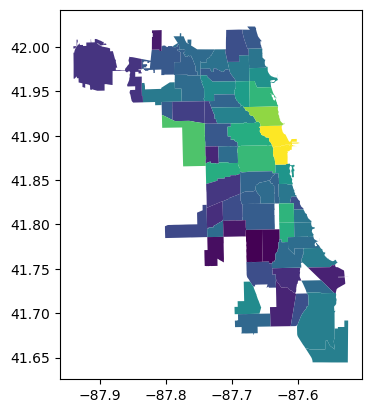

In [15]:
df.plot("price_pp")

In order to estimate the statistics, we need to get our data. We'll use the `price_pp` to get the price per person per night for Airbnbs in each neighborhood. And, we'll use the `crowded` column for the percentages of properties that are over-crowded. We'll build a simple contiguity weights matrix to explain the spatial adjacencies between neighborhoods. 

In [16]:
y = df.price_pp.values.reshape(-1,1)
x = df.crowded.values.reshape(-1,1)
w = graph.Graph.build_contiguity(df).transform("R")

Now, with these defined, we can calculate all of our statistics. First, we can note that each statistic corresponds to a different question of relation, like we discussed above: 

In [17]:
# are expensive places near expensive places?
Iy = Moran_Local(y, w)
# are crowded plcaes near crowded places?
Ix = Moran_Local(x, w) 
# are expensive places also crowded places? 
rho = pearsonr(y.squeeze(),x.squeeze())[0]
# are expensive places near crowded places?
Ixy = Moran_Local_BV(x, y, w) 
# are crowded places near expensive places?
Iyx = Moran_Local_BV(y, x, w)
# are expensive places near expensive places, adjusted for crowding?
p_lmo = Partial_Moran_Local().fit(x,y,w)
# assuming crowding explains price, 
# are places with high post-crowding premiums near one another?
a_lmo = Auxiliary_Moran_Local().fit(x,y,w)

# this is a scaling factor for the multivariable statistics
scaling = (w.n - 1)/(w.n) * (1/(1-rho**2))

Simulating by site: 100%|██████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 21919.71it/s]


You can then see that the multivariate estimators for the partial and auxiliary regressive versions of the Local Moran statistic are just combinations of these simple pairwise statistics when there is only one $x$ variable: 

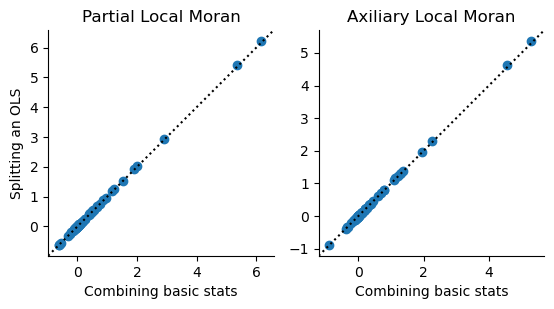

In [18]:
f,ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'))

ax[0].scatter(
    (Iy.Is - rho * Ixy.Is)*scaling, 
    p_lmo.associations_
)

ax[1].scatter(
    (Iy.Is - rho*Ixy.Is - rho*Iyx.Is + rho**2*Ix.Is)*scaling,
    a_lmo.associations_)

for i in range(2):
    xmin, xmax = ax[i].get_xlim()
    ymin, ymax = ax[i].get_ylim()
    left = min([xmin, ymin])
    right = max([xmax, ymax])
    ax[i].plot([left, right], [left, right], color='k', linestyle=":")
    ax[i].set_xlim(left, right)
    ax[i].set_ylim(left, right)
    if i==0:
        ax[i].set_ylabel("Splitting an OLS")
    ax[i].set_xlabel("Combining basic stats")
    ax[i].set_title(['Partial Local Moran', 'Axiliary Local Moran'][i])
    seaborn.despine(ax=ax[i])

You can see the direction of changes shown below. The changes in the partial statistic can only move from left to right, since the correction is only applied to $y$, not $\mathbf{W}y$. The component that "corrects" the $\mathbf{W}y$ for $x$ comes from that due to $\mathbf{W}x$, which arises in the auxiliary regression version, shown on the right. 


In [19]:
#| echo: false
def quadcolor(x,y, colors=None):
    off_sign = numpy.sign(y) != numpy.sign(x)
    neg_y = y < 0
    quad = off_sign + neg_y*2
    if colors is None:
        colors= numpy.array(['red','powderblue','steelblue','lightsalmon'])
    return colors[quad]

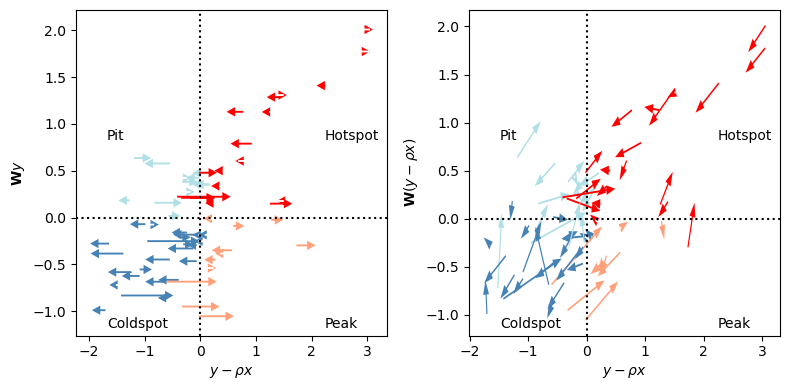

In [20]:
#| echo: false
f,ax = plt.subplots(1,2,figsize=(8,4))
for i,ax_ in enumerate(ax):
    start_x, start_y = Iy.z, Iy.w.sparse @ Iy.z
    new_x, new_y = (p_lmo.partials_.T, a_lmo.partials_.T)[i]
    dx, dy = new_x - start_x, new_y - start_y
    colors = quadcolor(new_x, new_y)
    for j in range(Iy.w.n):
        ax_.arrow(
            x=start_x[j], y=start_y[j],
            dx = dx[j], dy = dy[j],
            width=.02, shape='full', 
            length_includes_head=True, linewidth=0,
            head_width=.1, color=colors[j]
        )
    ax_.axvline(0, color='k', linestyle=':')
    ax_.axhline(0, color='k', linestyle=':')
    for j in range(2):
        for k in range(2):
            ax_.annotate(
                text=['Hotspot', 'Pit', 'Peak', 'Coldspot'][j+2*k],
                xy=(.1 if j else .8,
                    .025 if k else .6
                   ),
                xycoords="axes fraction"
            )
    ax_.set_xlabel(r"$y-\rho x$")
    ax_.set_ylabel((r"$\mathbf{W}y$", r"$\mathbf{W}(y-\rho x)$")[i])
f.tight_layout()
plt.show()

Here, we've colored the statistics according to their *new* quadrant. In the same fashion as a regular Local Moran statistic, we get quadrants that describe whether $y-\rho x$ is above or below the mean, (which, in both cases, is zero), and whether $\mathbf{W}y$ (or $\mathbf{W}(y - \rho x)$) is above or below its mean (which, again, is zero by construction). Further, you can note the four-part quadrant breakdown is explained by the annotations:

- A *hotspot* is an area where the observation under study is above its mean, and also above the surrounding mean.
- A *pit* is an area where the observation under study is below its mean, but is surrounded by observations larger than the mean. 
- A *coldspot* is a hotspot in reverse: observations are smaller than the mean, and surrounded by values smaller than the mean. 
- A *peak* is a pit in reverse: the observation under study is above the mean, but is surrounded by values below the mean. 

In the case of the multivariable statistics, the interpretation remains the same; we just change what values we're comparing at the site and surrounding. For the partial Moran, we compare the adjusted $y-\rho x$ to $\mathbf{W}y$, while the full Auxiliary Regression Moran compares $y - \rho x$ to $\mathbf{W}y - \rho \mathbf{W}x$. Further, it might help to recognize that arrows in the left plot represent *only* the lateral (left-right, horizontal) component of arrows in the right plot. The left plot shows how information conditions our *site-specific* judgement, while the right plot shows how information conditions our judgement about the entire relationship. The vertical component of those vectors corresponds to the contribution of the $\rho\mathbf{W}x$ component of the y-axis term. 

We can also center the arrows on a common axis. This will let us see at a higher level whether information about crowding changes our judgement about the pattern of prices in Chicago. 

In [21]:
#| echo: false
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    np = numpy
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, 
                     align='edge', width=widths, linewidth=1
                     )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

For the partial Moran, we can visualize the changes along the $y$ axis as different "arrows" pushing either left or right. This is fine because the correction is only be applied on the $x$ component. For the auxiliary Moran, we need to build a Rose diagram that maps the typical move in each direction. This puts the original $I_i$ value at the center of the diagram, and shows the number of moves that go in each of the directions. Longer bars/pie slices indicate more moves in that direction. 

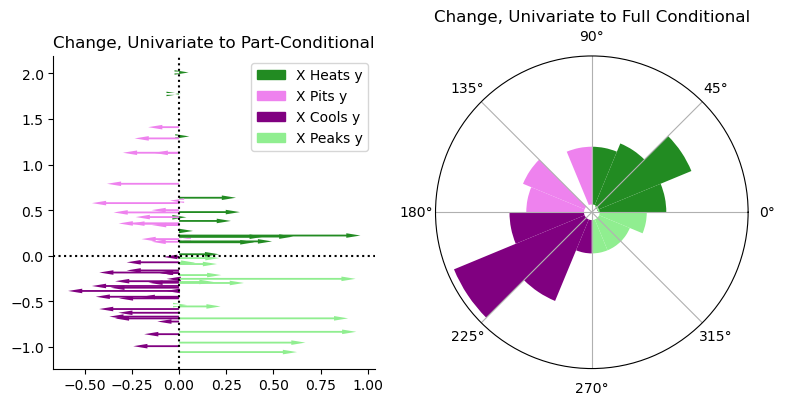

In [22]:
#| echo: false
f = plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2, projection='polar')
for i,ax_ in enumerate((ax1, ax2)):
    start_x, start_y = Iy.z, Iy.w.sparse @ Iy.z
    new_x, new_y = (p_lmo.partials_.T, a_lmo.partials_.T)[i]
    dx, dy = new_x - start_x, new_y - start_y
    colors = quadcolor(dx, dy if i > 0 else new_y,
                       colors=numpy.array(
                           ["forestgreen", 
                            "violet", 
                            "purple", 
                            "lightgreen"
                           ]
                       )
                      )
    if i == 0:
        for j in range(Iy.w.n):
            ax_.arrow(
                x=0, y=0 if i > 0 else start_y[j],
                dx = dx[j], dy = dy[j],
                width=.02, shape='full', 
                length_includes_head=True, linewidth=0,
                head_width=.05, color=colors[j]
            )
        ax_.axvline(0, color='k', linestyle=':')
        ax_.axhline(0, color='k', linestyle=':')
        ax1.set_title("Change, Univariate to Part-Conditional")
        seaborn.despine(ax=ax1)
        ax1.legend(
            handles = 
            [
                plt.arrow(0,0,1,0,
                          color=["forestgreen", "violet", "purple", "lightgreen"][i]) for i in range(4)
            ],
            labels = [
                "X Heats y", 
                "X Pits y", 
                "X Cools y", 
                "X Peaks y"
            ]
        )
    else:
        theta = numpy.arctan2(dy, dx)
        n, bins, patches = circular_hist(ax=ax2, x=theta, bins=16, gaps=False)
        for bin_, patch_ in zip(bins,patches.patches):
            if -numpy.pi/2 <= bin_ < 0:
                patch_.set_facecolor("lightgreen")
            elif 0 <= bin_ < numpy.pi/2:
                patch_.set_facecolor("forestgreen")
            elif numpy.pi/2 <= bin_ < numpy.pi:
                patch_.set_facecolor("violet")
            elif -numpy.pi <= bin_ < -numpy.pi/2:
                patch_.set_facecolor("purple")
        ax2.set_title("Change, Univariate to Full Conditional")
f.tight_layout()
plt.show()

From the partial statistic, you can see that most of the moves occur in the hotspot and coldspot quadrants, but quite a few very large moves push things towards "peaked"ness. These are many of the moves on the bottom right quadrant, where even a few observations shift from being a coldspot to being a peak. This means that they're in relatively low-priced areas, given their crowding levels. I refer to this as "x peaks y", since it indicates that $x$ pushes the local statistic towards the "peak" quadrant. Note that this does *not* indicate a change in classification, which we can see in a second. 

For the full conditional case, you can see from these diagrams that the inclusion of the crowding information pushes most strongly in the cluster/outlier direction. This means that the additional information about crowding increases our perception of how the price-per-person-per-night clusters spatially. 

To see the actual table of class changes (ignoring statistical significance for now), we can use `pandas` crosstabs to build the following nice tables:  

In [23]:
#| echo: false
#| #| jupyter: {source_hidden: false}
import pandas

partial_moves = pandas.crosstab(
            Iy.q,
            p_lmo.labels_,
        )
partial_moves.columns = partial_moves.index = ['hotspot', 'pit', 'coldspot', 'peak']
partial_moves.columns.name = "Partial"
partial_moves.index.name = "Univariate"

aux_moves = pandas.crosstab(
            Iy.q,
            a_lmo.labels_,
        )
aux_moves.columns = aux_moves.index = ['hotspot', 'pit', 'coldspot', 'peak']
aux_moves.columns.name = "Auxiliary"
aux_moves.index.name = "Univariate"

In [24]:
#| echo: false
partial_moves

Partial,hotspot,pit,coldspot,peak
Univariate,,,,
hotspot,14,3,0,0
pit,4,9,0,0
coldspot,0,0,24,3
peak,0,0,1,8


In [25]:
#| echo: false
aux_moves

Auxiliary,hotspot,pit,coldspot,peak
Univariate,,,,
hotspot,14,3,0,0
pit,4,7,2,0
coldspot,0,5,19,3
peak,2,0,1,6


From these, you can immediately see that the partial statistics can only move laterally. No observations moved from coldspot to anything other than "peak". That is, $x$ only affects our judgement about $y$, not $\mathbf{W}y$. In the bottom, however, you can see that moves exist across any quadrant. Although it is theoretically possible, no observations move in between hotspot and coldspot or peak and pit.

# Conclusion

In sum, the `Partial_Moran_Local` and `Auxiliary_Moran_Local` are great ways to control for "exogenous" variables $x$ that you think might be driving the pattern of your outcome. In this case, if you want to remove *everything* due to $x$ first, you should use the `Auxiliary_Moran_Local`, which is equivalent to regressing $x$ out of $y$ and analyzing the residuals for structure. However, it is often the case that we want to account for $x$ *without* assigning all of the variation in $y$ to $x$ alone. In this case, use the `Partial_Moran_Local` to recover an estimate of the relationship between a site's $y$ value and its surrounding $y$ values while fixing $x$ to a constant value. 

# A bit more formal aside: Fritsch-Waugh-Lovell to the rescue

For the econometricians in the room, there is an even better grounding than the graph-based argument from above to use the partial coefficient. If $\mathbf{X}$ is a collection of exogenous control matrices, we generally want to estimate $\rho$ and its partial products/local effects from the following Moran-form regression: 

$$ \mathbf{W}y = \mathbf{X}\beta + \rho y + \epsilon $$

How can we "get rid of" $\mathbf{X}\beta$ in our estimator for $\rho$? Well, the [Frisch-Waugh-Lovell](https://en.wikipedia.org/wiki/Frisch–Waugh–Lovell_theorem) lets us filter the regression to get back to a "regular" Moran-form regression with just $\mathbf{W}y$ and $y$. To do this, let $\mathbf{P}=\mathbf{I}-\mathbf{X}'(\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'$, and use FWL to re-state the regression above into a regression about the effect of $y$ on $\mathbf{W}y$ that is independent of $x$:

$$ \mathbf{P}\mathbf{W}y = I_{y|x} \mathbf{P} y + \epsilon $$

If you calculate this out, we get our estimator above. For the auxiliary regression strategy, you can think of $e$ as "what remains of $y$ that is independent of $x$. So, we would state $I_{x \rightarrow y}$ for our auxiliary regression would seek to find the effect of "what remains of $y$ that is independent of $x$" on the lag of "what remains of $y$ that is independent of $x$."

$$ \mathbf{W}\mathbf{P}y = I_{x \rightarrow y}\mathbf{P}y + \epsilon$$

The two are not equivalent because $\mathbf{WP}\neq\mathbf{PW}$ in general, even for symmetric $\mathbf{W}$ and $\mathbf{P}$; in practice, $\mathbf{P}$ is always symmetric, but $\mathbf{W}$ rarely is. Generally, we want $\mathbf{P}\mathbf{W}y$ as our outcome, not $\mathbf{W}\mathbf{P}y$. 
